Reference point data (closest to lower left corner):
image_name                                        DJI_0385_0142.JPG.tif
center_x                                                     562554.733
center_y                                                    4306617.851
bounding_box          (562548.7629999999, 4306609.071000001, 562560....
bounding_polygon      POLYGON ((562560.7029999999 4306609.071000001,...
distance_to_corner                                             3.911931
image_width                                                       11.94
image_height                                                      17.56
Name: 384, dtype: object
Smallest height in the dataset: 15.875
Percentage of uncovered area after initial sequence: 64.03%


C:\Users\woras\AppData\Local\Temp\ipykernel_17784\627348523.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = image_info_df.groupby('x_bin', as_index=False)
C:\Users\woras\AppData\Local\Temp\ipykernel_17784\627348523.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lowest_center_points = grouped.apply(lambda df: df.loc[df['center_y'].idxmin()])


Percentage of uncovered area after adding sequence 2: 33.68%
Percentage of uncovered area after adding sequence 3: 10.34%


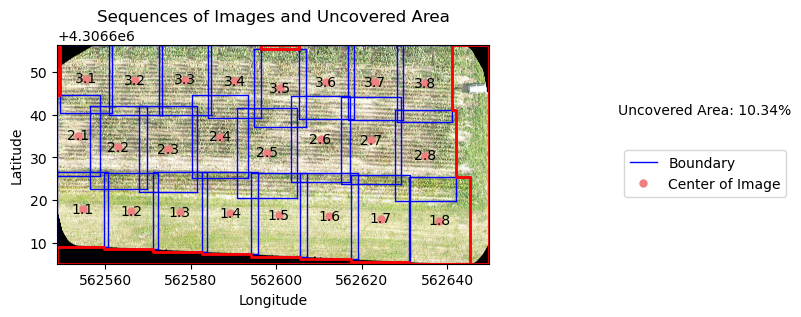

In [1]:
import numpy as np
from shapely.geometry import box, Polygon, MultiPolygon
import rasterio
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the dataset
orthophoto_path = 'D:/USDA/Piyush/Unorganized/odm_data_nb15/210825_m2pro_NB15/odm_orthophoto/odm_orthophoto.tif'
rectified_folder = 'D:/USDA/Piyush/Unorganized/odm_data_nb15/210825_m2pro_NB15/orthorectified/'

# Open the orthophoto dataset
ortho_dataset = rasterio.open(orthophoto_path)
rectified_path_list = glob.glob(rectified_folder + '/*.tif')

# Create a list to store information about each image
image_info_list = []

# Create bounding polygons and store information
for rectified_path in rectified_path_list:
    rectified_dataset = rasterio.open(rectified_path)
    bounding_box = rectified_dataset.bounds
    bounding_polygon = box(*bounding_box)
    center = bounding_polygon.centroid
    image_info = {
        'image_name': rectified_path.split('\\')[-1],
        'center_x': center.x,
        'center_y': center.y,
        'bounding_box': bounding_box,
        'bounding_polygon': bounding_polygon
    }
    image_info_list.append(image_info)

# Convert the list to a pandas DataFrame for easier manipulation
image_info_df = pd.DataFrame(image_info_list)

# Identify the lower left corner of the orthomosaic boundary
ortho_bounds = ortho_dataset.bounds
lower_left_corner = (ortho_bounds.left, ortho_bounds.bottom)

def distance_to_corner(bounding_box, corner):
    """
    Calculate the distance from the lower left corner to the bounding box.
    """
    return np.sqrt((bounding_box.left - corner[0]) ** 2 + (bounding_box.bottom - corner[1]) ** 2)

# Add distance to corner and image width/height to the DataFrame
image_info_df['distance_to_corner'] = image_info_df['bounding_box'].apply(lambda bb: distance_to_corner(bb, lower_left_corner))
image_info_df['image_width'] = image_info_df['bounding_box'].apply(lambda bb: bb.right - bb.left)
image_info_df['image_height'] = image_info_df['bounding_box'].apply(lambda bb: bb.top - bb.bottom)

# Identify the reference point (closest to lower left corner)
reference_point = image_info_df.loc[image_info_df['distance_to_corner'].idxmin()]
reference_width = reference_point['image_width']
reference_height = reference_point['image_height']

# Determine the smallest height in the entire dataset
smallest_height = image_info_df['image_height'].min()

print("Reference point data (closest to lower left corner):")
print(reference_point)
print(f"Smallest height in the dataset: {smallest_height}")

def filter_lowest_center_points(image_info_df, reference_point, reference_width):
    """
    Filter images by the lowest center points in bins defined by 20% of the reference point's width.
    """
    x_width = reference_width * 0.2
    bins = np.arange(image_info_df['center_x'].min(), image_info_df['center_x'].max() + x_width, x_width)
    image_info_df['x_bin'] = pd.cut(image_info_df['center_x'], bins=bins, include_lowest=True)
    grouped = image_info_df.groupby('x_bin', as_index=False)
    lowest_center_points = grouped.apply(lambda df: df.loc[df['center_y'].idxmin()])

    if reference_point.name not in lowest_center_points.index:
        lowest_center_points = pd.concat([lowest_center_points, reference_point.to_frame().T])

    return lowest_center_points

# Apply the filter
lowest_center_points = filter_lowest_center_points(image_info_df, reference_point, reference_width)

# Sort the lowest center points by ascending x-coordinates
lowest_center_points_sorted = lowest_center_points.sort_values(by='center_x').reset_index(drop=True)

def calculate_overlap_area(bbox1, bbox2):
    """
    Calculate the overlap area between two bounding boxes.
    """
    poly1 = box(*bbox1)
    poly2 = box(*bbox2)
    intersection = poly1.intersection(poly2)
    return intersection.area / poly1.area, intersection.area / poly2.area

def find_next_images(lowest_center_points_sorted, reference_point):
    """
    Find the sequence of images with 5-25% overlap from the sorted lowest center points.
    """
    current_image = reference_point
    sequence = [current_image]
    current_index = reference_point.name

    while True:
        candidates = lowest_center_points_sorted[(lowest_center_points_sorted['center_x'] > current_image['center_x']) & (lowest_center_points_sorted.index != current_index)]
        found = False
        for idx, candidate in candidates.iterrows():
            overlap1, overlap2 = calculate_overlap_area(current_image['bounding_box'], candidate['bounding_box'])
            if 0.01 <= overlap2 <= 0.15:
                sequence.append(candidate)
                current_image = candidate
                current_index = idx
                found = True
                break
        if not found:
            break

    return sequence

def find_image_sequence(lowest_center_points_sorted):
    """
    Main function to find the sequence of images, restarting if necessary.
    """
    sequence = []
    remaining_points = lowest_center_points_sorted.copy()
    
    while not sequence or (len(sequence) < len(lowest_center_points_sorted) and not remaining_points.empty):
        reference_point = remaining_points.iloc[0]
        new_sequence = find_next_images(remaining_points, reference_point)

        if len(new_sequence) > len(sequence):
            sequence = new_sequence

        remaining_points = remaining_points[~remaining_points.index.isin([img.name for img in new_sequence])]

    return sequence

# Find the sequence of images starting from the initial reference point
sequence = find_image_sequence(lowest_center_points_sorted)

# Convert the sequence to a DataFrame and add a sequence number
sequence_df = pd.DataFrame(sequence)
sequence_df['sequence_number'] = 1
sequence_df['image_sequence_number'] = range(1, len(sequence_df) + 1)

def find_uncovered_area(ortho_bounds, selected_sequences):
    """
    Find the uncovered area by the selected sequences.
    """
    ortho_polygon = box(*ortho_bounds)
    selected_polygons = [box(*row['bounding_box']) for _, row in selected_sequences.iterrows()]
    union_selected_polygons = selected_polygons[0]
    for poly in selected_polygons[1:]:
        union_selected_polygons = union_selected_polygons.union(poly)
    uncovered_area = ortho_polygon.difference(union_selected_polygons)
    return uncovered_area

# Find the uncovered area after the initial sequence
uncovered_area = find_uncovered_area(ortho_bounds, sequence_df)

# Calculate the percentage of the uncovered area
uncovered_area_percentage = (uncovered_area.area / box(*ortho_bounds).area) * 100
print(f"Percentage of uncovered area after initial sequence: {uncovered_area_percentage:.2f}%")

sequence_number = 2
all_sequences_df = sequence_df.copy()

while uncovered_area_percentage > 20:
    def find_images_above_sequence(previous_sequence, image_info_df, smallest_height):
        """
        Find a new sequence of images above the previous sequence.
        """
        height_range_min = smallest_height * 0.70
        height_range_max = smallest_height * 1.10

        max_center_y = previous_sequence['center_y'].max()

        above_sequence_df = image_info_df[(image_info_df['center_y'] > max_center_y + height_range_min) &
                                          (image_info_df['center_y'] < max_center_y + height_range_max)]

        valid_images = []
        for _, above_image in above_sequence_df.iterrows():
            for _, below_image in previous_sequence.iterrows():
                overlap1, overlap2 = calculate_overlap_area(above_image['bounding_box'], below_image['bounding_box'])
                if 0.01 <= overlap2 <= 0.15:
                    valid_images.append(above_image)
                    break

        if valid_images:
            above_sequence_filtered = pd.DataFrame(valid_images)
            above_sequence_sorted = above_sequence_filtered.sort_values(by='center_x').reset_index(drop=True)
        else:
            above_sequence_sorted = pd.DataFrame()

        return above_sequence_sorted

    above_sequence_sorted = find_images_above_sequence(all_sequences_df[all_sequences_df['sequence_number'] == sequence_number - 1], image_info_df, smallest_height)

    if above_sequence_sorted.empty:
        print(f"No valid images found for sequence {sequence_number}. Stopping the process.")
        break

    new_sequence = find_image_sequence(above_sequence_sorted)

    new_sequence_df = pd.DataFrame(new_sequence)
    new_sequence_df['sequence_number'] = sequence_number
    new_sequence_df['image_sequence_number'] = range(1, len(new_sequence_df) + 1)

    all_sequences_df = pd.concat([all_sequences_df, new_sequence_df])
    uncovered_area = find_uncovered_area(ortho_bounds, all_sequences_df)
    uncovered_area_percentage = (uncovered_area.area / box(*ortho_bounds).area) * 100
    print(f"Percentage of uncovered area after adding sequence {sequence_number}: {uncovered_area_percentage:.2f}%")

    sequence_number += 1

# Reorder columns to move 'sequence_number' and 'image_sequence_number' to the front
cols = ['sequence_number', 'image_sequence_number'] + [col for col in all_sequences_df.columns if col not in ['sequence_number', 'image_sequence_number']]
all_sequences_df = all_sequences_df[cols]

def plot_image_centers_and_boundaries_with_uncovered(ortho_bounds, all_sequences_df, uncovered_area, ortho_image_path, title=""):
    """
    Plot the centers and boundaries of images and the uncovered area.
    """
    fig, ax = plt.subplots()
    with rasterio.open(ortho_image_path) as ortho_image:
        ortho_image_data = ortho_image.read([1, 2, 3])
        ortho_image_data = np.dstack(ortho_image_data)
        ortho_image_bounds = ortho_image.bounds
        extent = [ortho_image_bounds.left, ortho_image_bounds.right, ortho_image_bounds.bottom, ortho_image_bounds.top]
        ax.imshow(ortho_image_data, extent=extent, origin='upper')

    for sequence_number in all_sequences_df['sequence_number'].unique():
        sequence_df = all_sequences_df[all_sequences_df['sequence_number'] == sequence_number]
        for _, row in sequence_df.iterrows():
            bx, by = row['bounding_polygon'].exterior.xy
            ax.plot(bx, by, 'b-', lw=1, label='Boundary' if sequence_number == 1 and _ == 0 else "")
            ax.plot(row['center_x'], row['center_y'], 'o', color='lightcoral', markersize=5, label='Center of Image' if sequence_number == 1 and _ == 0 else "")
            ax.text(row['center_x'], row['center_y'], f'{row["sequence_number"]}.{row["image_sequence_number"]}', color='black', fontsize=10, ha='center', va='center')
    if isinstance(uncovered_area, MultiPolygon):
        for geom in uncovered_area.geoms:
            ux, uy = geom.exterior.xy
            ax.plot(ux, uy, 'r-', lw=2, label='Uncovered Area' if sequence_number == 1 else "")
    else:
        ux, uy = uncovered_area.exterior.xy
        ax.plot(ux, uy, 'r-', lw=2, label='Uncovered Area')
    
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    uncovered_area_text = f'Uncovered Area: {uncovered_area_percentage:.2f}%'
    plt.text(1.5, 0.7, uncovered_area_text, ha='center', va='center', transform=ax.transAxes, fontsize=10)

    plt.subplots_adjust(right=0.8, bottom=0.2)
    plt.show()

plot_image_centers_and_boundaries_with_uncovered(ortho_bounds, all_sequences_df, uncovered_area, orthophoto_path, title="Sequences of Images and Uncovered Area")

# Save the all_sequences_df DataFrame to CSV
all_sequences_df.to_csv('all_sequences.csv', index=False)